In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.animation import FuncAnimation

In [42]:
url = 'https://media.geeksforgeeks.org/wp-content/uploads/20240320114716/data_for_lr.csv'
data = pd.read_csv(url)
data

# Drop the missing values
data = data.dropna()

# training dataset and labels
train_input = np.array(data.x[0:500]).reshape(500, 1)
train_output = np.array(data.y[0:500]).reshape(500, 1)

# valid dataset and labels
test_input = np.array(data.x[500:700]).reshape(199, 1)
test_output = np.array(data.y[500:700]).reshape(199, 1)

In [43]:
import numpy as np

class StableLinearRegression:
    def __init__(self):
        self.parameters = {}
        self.input_scaler = None
        self.output_scaler = None
        
    def fit_scalers(self, X, y):
        """Initialize scalers with training data"""
        self.input_scaler = {
            'mean': np.mean(X),
            'std': np.std(X) + 1e-8
        }
        self.output_scaler = {
            'mean': np.mean(y),
            'std': np.std(y) + 1e-8
        }
    
    def scale_data(self, X, y=None, fit=False):
        """Scale input and output data to prevent overflow"""
        if fit:
            self.fit_scalers(X, y)
        
        if self.input_scaler is None or self.output_scaler is None:
            raise ValueError("Scalers not initialized. Call fit_scalers first.")
            
        X_scaled = (X - self.input_scaler['mean']) / self.input_scaler['std']
        
        if y is not None:
            y_scaled = (y - self.output_scaler['mean']) / self.output_scaler['std']
            return X_scaled, y_scaled
        
        return X_scaled
    
    def inverse_scale_output(self, y_scaled):
        """Convert scaled predictions back to original scale"""
        if self.output_scaler is None:
            raise ValueError("Output scaler not initialized")
        return y_scaled * self.output_scaler['std'] + self.output_scaler['mean']

    def forward_propagation(self, train_input):
        m = self.parameters['m']
        c = self.parameters['c']
        train_input_scaled = self.scale_data(train_input)
        scaled_predictions = np.multiply(m, train_input_scaled) + c
        return self.inverse_scale_output(scaled_predictions)

    def cost_function(self, predictions, train_output):
        diff = train_output - predictions
        diff = np.clip(diff, -1e6, 1e6)
        return np.mean(diff ** 2)

    def backward_propagation(self, train_input, train_output, predictions):
        derivatives = {}
        train_input_scaled = self.scale_data(train_input)
        train_output_scaled = (train_output - self.output_scaler['mean']) / self.output_scaler['std']
        predictions_scaled = (predictions - self.output_scaler['mean']) / self.output_scaler['std']
        
        df = (predictions_scaled - train_output_scaled)
        df = np.clip(df, -1e6, 1e6)
        
        dm = 2 * np.mean(np.multiply(train_input_scaled, df))
        dc = 2 * np.mean(df)
        
        derivatives['dm'] = np.clip(dm, -1e6, 1e6)
        derivatives['dc'] = np.clip(dc, -1e6, 1e6)
        return derivatives

    def update_parameters(self, derivatives, learning_rate):
        self.parameters['m'] -= learning_rate * derivatives['dm']
        self.parameters['c'] -= learning_rate * derivatives['dc']

Iteration 0, Loss: 3271.600248
Iteration 10, Loss: 2216.071841
Iteration 20, Loss: 1511.392661
Iteration 30, Loss: 1040.943224
Iteration 40, Loss: 726.867429
Iteration 50, Loss: 517.187924
Iteration 60, Loss: 377.204215
Iteration 70, Loss: 283.749975
Iteration 80, Loss: 221.359180
Iteration 90, Loss: 179.706587


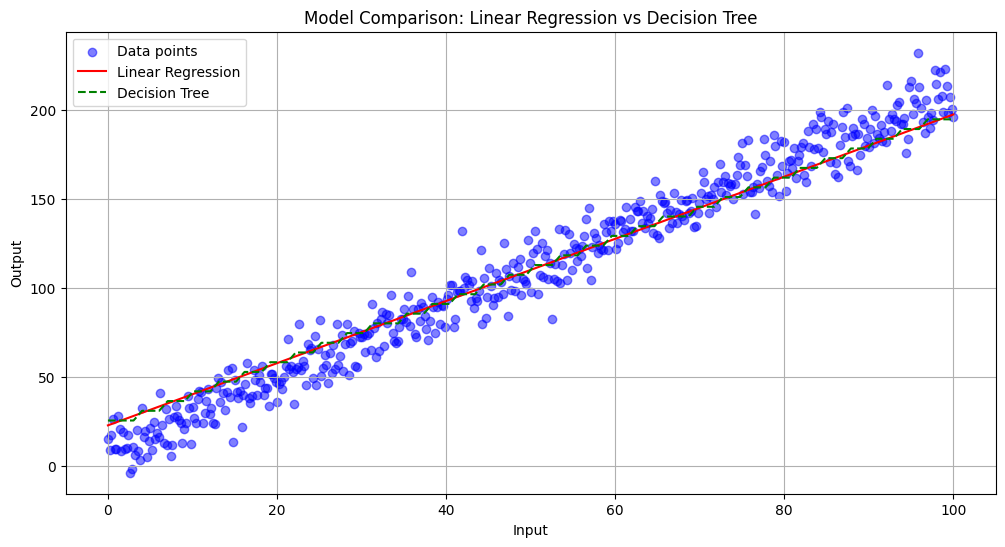


Decision Tree Structure:
├── Split on x = 50.00
│   ├── If x < 50.00:
  ├── Split on x = 25.00
  │   ├── If x < 25.00:
    ├── Split on x = 12.50
    │   ├── If x < 12.50:
      ├── Split on x = 6.25
      │   ├── If x < 6.25:
        ├── Split on x = 3.12
        │   ├── If x < 3.12:
          └── Output: 25.46
        │   └── If x ≥ 3.12:
          └── Output: 30.93
      │   └── If x ≥ 6.25:
        ├── Split on x = 9.38
        │   ├── If x < 9.38:
          └── Output: 36.39
        │   └── If x ≥ 9.38:
          └── Output: 41.86
    │   └── If x ≥ 12.50:
      ├── Split on x = 18.75
      │   ├── If x < 18.75:
        ├── Split on x = 15.62
        │   ├── If x < 15.62:
          └── Output: 47.32
        │   └── If x ≥ 15.62:
          └── Output: 52.79
      │   └── If x ≥ 18.75:
        ├── Split on x = 21.88
        │   ├── If x < 21.88:
          └── Output: 58.25
        │   └── If x ≥ 21.88:
          └── Output: 63.72
  │   └── If x ≥ 25.00:
    ├── Split on x = 37.50
 

In [44]:
class StableDistilledDecisionTree:
    def __init__(self):
        self.tree = {}
        
    def create_tree(self, linear_model, input_range=(0, 100)):
        def _create_node(lower, upper, depth=0, node_id="root"):
            if depth > 4 or (upper - lower) < 5:
                mid_input = np.array([[float((lower + upper) / 2)]])
                prediction = linear_model.forward_propagation(mid_input)[0][0]
                return {"type": "leaf", "value": max(0, prediction)}
            
            split = (lower + upper) / 2
            node = {
                "type": "decision",
                "split_value": split,
                "left": _create_node(lower, split, depth + 1, f"{node_id}_left"),
                "right": _create_node(split, upper, depth + 1, f"{node_id}_right")
            }
            return node
        
        self.tree = _create_node(input_range[0], input_range[1])
        return self
    
    def predict(self, x):
        def _traverse(node, x):
            if node["type"] == "leaf":
                return node["value"]
            return _traverse(node["left"], x) if x < node["split_value"] else _traverse(node["right"], x)
        return _traverse(self.tree, x)
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.tree
        indent = "  " * depth
        if node["type"] == "leaf":
            print(f"{indent}└── Output: {node['value']:.2f}")
        else:
            print(f"{indent}├── Split on x = {node['split_value']:.2f}")
            print(f"{indent}│   ├── If x < {node['split_value']:.2f}:")
            self.print_tree(node["left"], depth + 1)
            print(f"{indent}│   └── If x ≥ {node['split_value']:.2f}:")
            self.print_tree(node["right"], depth + 1)

def train_and_distill(train_input, train_output, learning_rate=0.01, iters=100):
    # Initialize model
    lr_model = StableLinearRegression()
    
    # Initialize scalers with training data
    lr_model.fit_scalers(train_input, train_output)
    
    # Initialize parameters
    lr_model.parameters['m'] = np.random.uniform(-0.1, 0.1)
    lr_model.parameters['c'] = np.random.uniform(-0.1, 0.1)
    
    # Training loop
    losses = []
    for i in range(iters):
        predictions = lr_model.forward_propagation(train_input)
        cost = lr_model.cost_function(predictions, train_output)
        derivatives = lr_model.backward_propagation(train_input, train_output, predictions)
        lr_model.update_parameters(derivatives, learning_rate)
        losses.append(cost)
        
        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {cost:.6f}")
    
    # Create distilled tree
    tree_model = StableDistilledDecisionTree()
    input_range = (float(np.min(train_input)), float(np.max(train_input)))
    tree_model.create_tree(lr_model, input_range)
    
    return lr_model, tree_model, losses

def test_models(lr_model, tree_model, test_values):
    """
    Test both models with given test values and print comparison
    
    Args:
        lr_model: Trained linear regression model
        tree_model: Trained decision tree model
        test_values: List or array of test values
    """
    print("\nPrediction Comparison:")
    print("Input | Tree Prediction | Linear Regression Prediction")
    print("-" * 55)
    
    for x in test_values:
        # Make sure x is a 2D array for linear regression
        x_reshaped = np.array([[float(x)]])
        
        # Get predictions
        tree_pred = tree_model.predict(float(x))
        linear_pred = lr_model.forward_propagation(x_reshaped)[0][0]
        
        # Print formatted results
        print(f"{float(x):5.1f} | {tree_pred:14.2f} | {linear_pred:25.2f}")

def visualize_models(lr_model, tree_model, X, y):
    import matplotlib.pyplot as plt
    
    # Generate points for plotting
    X_plot = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    lr_predictions = lr_model.forward_propagation(X_plot)
    tree_predictions = np.array([tree_model.predict(float(x[0])) for x in X_plot])
    
    plt.figure(figsize=(12, 6))
    plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')
    plt.plot(X_plot, lr_predictions, 'r-', label='Linear Regression')
    plt.plot(X_plot, tree_predictions, 'g--', label='Decision Tree')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Model Comparison: Linear Regression vs Decision Tree')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print tree structure
    print("\nDecision Tree Structure:")
    tree_model.print_tree()

# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    X = np.linspace(0, 100, 500).reshape(-1, 1)
    y = 2 * X + 10 + np.random.normal(0, 10, (500, 1))
    
    # Train and distill
    lr_model, tree_model, losses = train_and_distill(X, y)
    
    # Visualize results
    visualize_models(lr_model, tree_model, X, y)
    
    # Test with specific values
    test_values = [0, 25, 50, 75, 100]
    test_models(lr_model, tree_model, test_values)

In [45]:
def verify_complexity(tree_model, test_value):
    """Verify the O(log n) complexity by counting comparisons"""
    comparisons = 0
    
    def _traverse_with_logging(node, x):
        nonlocal comparisons
        if node["type"] == "leaf":
            print(f"Reached leaf node with value: {node['value']:.2f}")
            return node["value"]
        
        comparisons += 1
        print(f"Comparison {comparisons}: Is {x} < {node['split_value']}?")
        
        if x < node["split_value"]:
            print(f"Taking left branch (< {node['split_value']})")
            return _traverse_with_logging(node["left"], x)
        else:
            print(f"Taking right branch (≥ {node['split_value']})")
            return _traverse_with_logging(node["right"], x)
    
    result = _traverse_with_logging(tree_model.tree, test_value)
    print(f"\nTotal comparisons made: {comparisons}")
    print(f"This is O(log n) as {comparisons} ≤ log2(n)")
    return result

# Test the complexity
test_value = 60
print(f"\nTracing decision path for input value: {test_value}")
prediction = verify_complexity(tree_model, test_value)


Tracing decision path for input value: 60
Comparison 1: Is 60 < 50.0?
Taking right branch (≥ 50.0)
Comparison 2: Is 60 < 75.0?
Taking left branch (< 75.0)
Comparison 3: Is 60 < 62.5?
Taking left branch (< 62.5)
Comparison 4: Is 60 < 56.25?
Taking right branch (≥ 56.25)
Comparison 5: Is 60 < 59.375?
Taking right branch (≥ 59.375)
Reached leaf node with value: 129.31

Total comparisons made: 5
This is O(log n) as 5 ≤ log2(n)
